### Task 1: Image classification

In [1]:
import sys, os
import matplotlib.pyplot as plt
import numpy as np
CURR_DIR = os.path.dirname('__file__')
ROOT_DIR=os.path.join(os.getcwd() ,'..')
sys.path.append(ROOT_DIR)

In [2]:
from omegaconf import OmegaConf
#load configs
config = OmegaConf.load(os.path.join(ROOT_DIR,'run_scripts/configs/config_t2_cnnlstm.yaml'))

In [3]:
import wandb
!wandb login

wandb: Currently logged in as: pimakshay (thesis-dm). Use `wandb login --relogin` to force relogin


In [3]:
from utilities.initialize_configs import instantiate_from_configs
classifierModel = instantiate_from_configs(config.model)
gpu_version = '271865_cnn_run0'

2024-01-24 14:45:25.314048: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-24 14:45:25.314071: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
%%capture
classifierModel.cuda()

In [4]:
for batch in classifierModel.train_dataloader():
    print(batch[1].size())
    break

torch.Size([16])


In [5]:
classifierModel.model

CNNLSTMModel(
  (cnnetwork): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(360000, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=7, bias=True)
)

In [4]:
%%capture
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import TQDMProgressBar, Timer, ModelCheckpoint
import time
from pytorch_lightning.loggers import WandbLogger

# stop training after 12 hours
timer = Timer(duration="00:12:00:00")

# or provide a datetime.timedelta
from datetime import timedelta
timer = Timer(duration=timedelta(weeks=1))
timestr = time.strftime("%d%m%y-%H%M%S")
loss_type = classifierModel.loss_type
alpha = classifierModel.learning_rate
task = 'lstm-classification'

wandb_logger = WandbLogger(project="conxai",   
           entity="pimakshay",       # Team
           group=task,       # for organizing runs (e.g. distributed training)
           name=timestr, # name of the run
           notes='running lstm network', # commit message in git
           sync_tensorboard=True)

CKPT_DIR = '/dss/dssfs02/lwp-dss-0001/pn69re/pn69re-dss-0000/ge59suz2/lightning_logs/' + task
CKPT_DIR = CKPT_DIR + '/'+gpu_version+'/checkpoints'
checkpoint = ModelCheckpoint(
    dirpath=CKPT_DIR,
    save_top_k=2,
    monitor="val/loss",    
    filename=timestr + "-{epoch}-{step}-" + "-loss=%s"%loss_type + "-a=%.1E"%alpha
)

trainer = Trainer(max_steps=classifierModel.max_tsteps, callbacks=[TQDMProgressBar(refresh_rate=10), timer, checkpoint]) # To use all available GPUs put -1 or '-1'
trainer.fit(classifierModel)

# query training/validation/test time (in seconds)
print("Total training time: %.2f mins" % (timer.time_elapsed("train")/60))

# save last checkpoint
timestr = time.strftime("%d%m%y-%H%M%S")
train_loss = "{:.4f}".format(trainer.logged_metrics['train/loss'].item())
CKPT_NAME = timestr + "_lastckpt_tloss_" + str(train_loss) + ".ckpt"
logger_version = "version_"+str(trainer.logger.version)
PATH = "lightning_logs/" + logger_version+ "/checkpoints/"+CKPT_NAME
trainer.save_checkpoint(PATH)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type         | Params
---------------------------------------
0 | model | CNNLSTMModel | 184 M 
---------------------------------------
184 M     Trainable params
0         Non-trainable params
184 M     Total params
738.156   Total estimated model params size (MB)
2024-01-24 14:46:10.040331: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-24 14:46:10.040370: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Model Evaluation

In [5]:
import numpy as np
import torch

batch_size=classifierModel.batch_size

test_dataloader = torch.utils.data.DataLoader(
    dataset=classifierModel.test_dataset, batch_size=batch_size, num_workers=4, shuffle=True
)

for step, (x,y) in enumerate(test_dataloader):
    break


In [6]:
import torch.nn.functional as F
outputs = classifierModel.model(x)

In [7]:
pred = torch.max(F.softmax(outputs),dim=1)
score = pred.values.tolist()
idx = pred.indices.tolist()

/home/akshay/miniconda3/envs/fleetsim/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


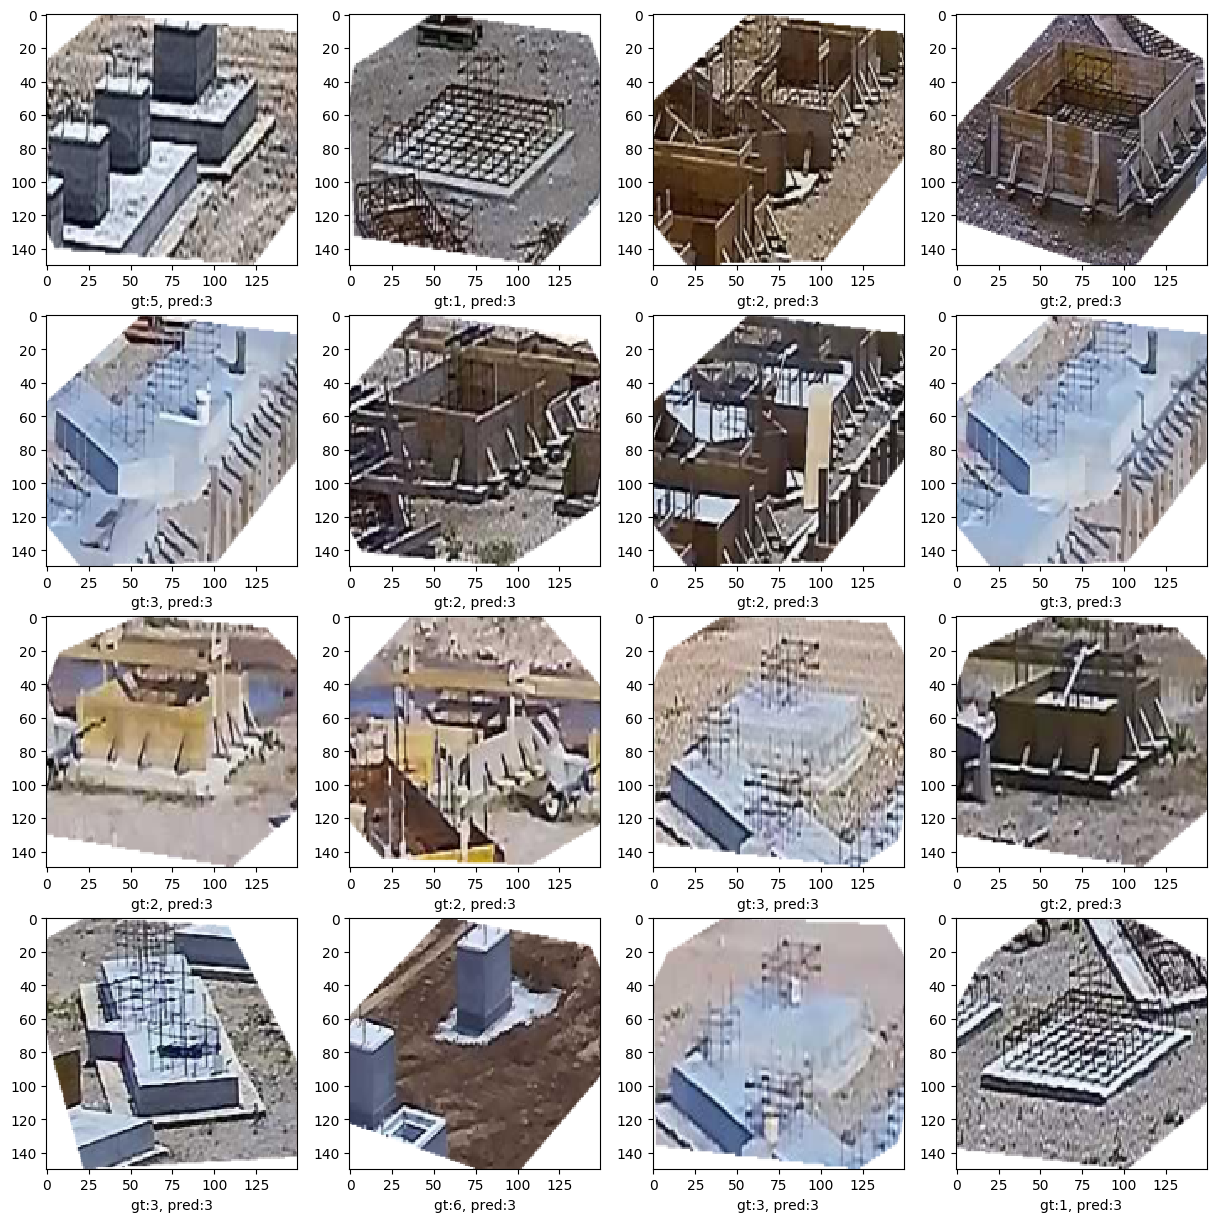

<Figure size 640x480 with 0 Axes>

In [8]:
nrows=4
ncols=batch_size//nrows
f, axs = plt.subplots(nrows, ncols, figsize=(15, 15))
for i in range(nrows):
    for j in range(ncols):
        axs[i][j].imshow(x[i*ncols + j].permute(1,2,0))
#         axs[i][j].set_xlabel("gt:"+classifierModel.class_labels_dict[y[i*ncols + j].item()] 
#                              + ", pred:"+classifierModel.class_labels_dict[idx[i*ncols + j]])
        axs[i][j].set_xlabel("gt:"+str(y[i*ncols + j].item()) 
                            + ", pred:"+str(idx[i*ncols + j]))
plt.show()

import random
rand = random.randint(0, 20)
plt.savefig("results/cnnlstm/plots_bs"+str(batch_size)+"_seed_"+str(rand)+".png")

Accuracy Analysis

In [9]:
def accuracy(preds, labels):
#     _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [10]:
accuracy(pred.indices, y)

tensor(0.3125)

wandb: Network error (ConnectionError), entering retry loop.
